(c) Juan Gomez y Nicolas Guarin-Zapata 2020.This material is part of the course Introduction to Finite Element Analysis

# <center>Perdidad de calidad de la solución en el MEFs basado en desplazamientos en condiciones de casi-incompresibilidad.</center>

<br>

### Nicolás Guarín-Zapata


<img style="float: right;"
     src="./img/logo.svg"
     width="320"
     height="50">
     

     
<br>
Junio 12 - Mecánica Aplicada
<br>

## Introducción.

En el método de los elementos finitos aplicado a problemas de teoría linealizada de la elasticidad y basado en el principio de desplazamientos virtuales se asume como variable primaria el campo de desplazamientos. Como resultado las ecuaciones de equilibrio a nivel del continuo se transforman, vía discretización combinada con interpolación, en un sistema de ecuaciones lineales algebraicas en las que las incognitas son los desplazameintos nodales en los elementos de la malla. Aunque esta formulación produce resultados aceptables para la mayoría de sólidos bajo condiciones elásticas la calidad de la solución parece degradarse a medida que la relación de Poisson se acerca al limite de incompresibilidad $(\nu = 0.5)$. En este proyecto se describe mediante simulaciones la degradación de los resultados del análisis a medida que el material se acerca a esta condición. **El entendimiento de dichas patologías numéricas, inherentes al método es importante en la correcta apliación e interpretación de los resultados de simulaciones. En partícular, acá se muestra como realizar una inspección visual de los resultados y de su calidad.**

## Descripción de archivos.

Para ejecutar los análisis se requieren los archivos correspondientes a la malla de gmsh y correspondientes a **bracket.geo** y **bracket.msh** disponibles en la carpeta **files**. Adicionalmente, todas las imagenes usadas en el notebook se encuentran en la carpeta **img**.

## Descripción del problema

Para estudiar el efecto de la relación de Poisson en la degradación de la solución por elementos finitos basados en desplazamientos se usará el modelo propuesto en Bathe(1996) mostrado en la figura. El sólido corresponde a una placa anclada en su extremo izquierdo y sometida a tracciones normales a la superficie superior. Para realizar el análisis se implementará una nueva rutina que convierte de el vector de tracciones en la superficie en cargas nodales. Para identificar la degradación de la solución se realizarán análisis con diferentes relaciones de Poisson.

<center><img src="img/bracket.png" alt="files" style="width:500px"></center>

## Análisis

In [78]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import meshio
import solidspy.assemutil as ass
import solidspy.solutil as sol
import solidspy.femutil as fe
import solidspy.postprocesor as pos

### Subrutinas adicionales no disponibles en SolidsPy

In [79]:
def int_tract(eles, coords, traction, loads):
    """
    Calcula el vector de fuerzas nodales
    consistente con el vector de tracciones.    
    """
    tx, ty = traction
    M = np.array([
		[4,	-1, 2],
		[-1, 4, 2],
		[2,	2, 16]])
    M = M/15
    tracs = np.array([[tx, tx, tx], [ty, ty, ty]]).T
    for ele in eles:
        length = np.linalg.norm(coords[ele[0]] - coords[ele[1]])
        loc_force = M @ tracs * length/2
        loads[ele, 1:] += loc_force
    return None

In [80]:
def strain_tris(nodes, elements, mats, disp):
    """
    Calcula deformaciones unitarias y tensiones sobre triangulos.
    La triangulación resulta de la partición de los elementos
    en triangulos lineales- Las deformaciones y tensiones son evaluadas
    en los baricentros de cada triangulo.

    Parametros
    ----------
    nodes : ndarray (float).
        Arreglo con coordenadas nodales.
    elements : ndarray (int)
        Arreglo con informacion elemental definida como
        en SolidsPy
    mats : ndarray (float)
        Tuple con propiedades del material.
    disp : ndarray (float)
        Arreglo completo (calculados e impuestos) de
        desplazamientos nodales.

    Returns
    -------
    E_tris : ndarray
        Deformaciones evaluadas sobre los baricentros
        de los triangulos.
    S_tris : ndarray
        TEnsiones evaluadas sobre los baricentros
        de los triangulos..
    """
    tris = pos.mesh2tri(nodes, elements)
    E_tris = np.empty_like(tris.triangles, dtype=np.float)
    S_tris = np.empty_like(tris.triangles, dtype=np.float)
    young, poisson = mats
    shear = young/(2*(1 + poisson))
    fact1 = young/(1 - poisson**2)
    fact2 = poisson*young/(1 - poisson**2)
    for cont, tri in enumerate(tris.triangles):
        _, B = fe.stdm3NT(1/3, 1/3, nodes[tri, 1:3])
        disp_loc = disp[tri, :]
        disp_loc.shape = 6
        strain = B @ disp_loc
        E_tris[cont, :] = strain
        S_tris[cont, 0] = fact1*strain[0] + fact2*strain[1]
        S_tris[cont, 1] = fact2*strain[1] + fact1*strain[1]
        S_tris[cont, 2] = shear*strain[2]
    return E_tris, S_tris, tris

#### Pre-procesado

In [81]:
mesh   = meshio.read('files/bracket.msh')
points = mesh.points
cells  = mesh.cells
tri6   = cells["triangle6"]
line3  = cells["line3"]
vertex = cells["vertex"]
line3_data = mesh.cell_data["line3"]["gmsh:physical"]

#### Parametros de la simulación.

In [82]:
npts  = points.shape[0]
nodes = np.zeros((npts, 5))
nodes[vertex, 3:] = -1
nodes[:, 1:3] = points[:, :2]

nels = tri6.shape[0]
elements = np.zeros((nels, 9), dtype=int)
elements[:, 1] = 2
elements[:, 3:] = tri6

#### Propiedades del material

In [83]:
mats = np.array([[55.0, 0.35]])

#### Ensamblaje

In [84]:
assem_op, bc_array, neq = ass.DME(nodes, elements)
stiff_mat = ass.assembler(elements, mats, nodes, neq, assem_op)

Vector de tracciones

In [85]:
P = -0.006
loads = np.zeros((npts, 3))
loads[:, 0] = range(0, npts)
vert_load = line3[line3_data == 3]
curv_load = line3[line3_data == 4]
hor_load  = line3[line3_data == 5]
int_tract(vert_load, points[:, :2], (0, P), loads)
int_tract(curv_load, points[:, :2], (np.sqrt(2)*P/2, np.sqrt(2)*P/2), loads)
int_tract(hor_load, points[:, :2], (P, 0), loads)
rhs_vec = ass.loadasem(loads, bc_array, neq)

#### Solución y post-procesado

In [86]:
disp = sol.static_sol(stiff_mat, rhs_vec)

#%% Post-processing
disp_complete = pos.complete_disp(bc_array, nodes, disp)
node_fields = False

## Node fields
if node_fields:
    strain_nodes, stress_nodes = pos.strain_nodes(nodes, elements, mats,
                                        disp_complete)
    pos.fields_plot(elements, nodes, disp_complete, E_nodes=strain_nodes,
                    S_nodes=stress_nodes)

<IPython.core.display.Javascript object>


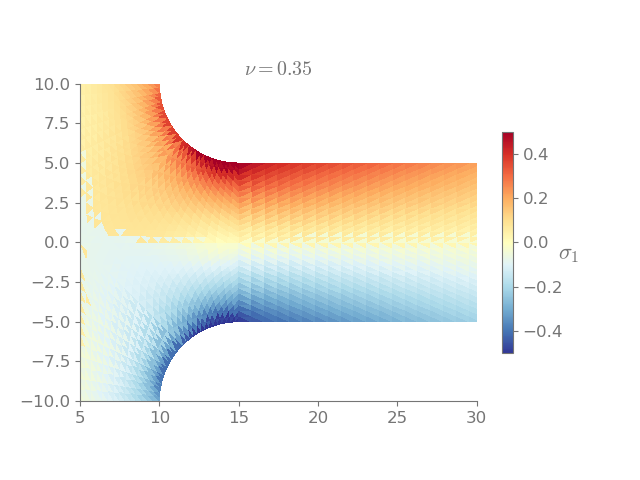

Text(0.5, 1.0, '$\\nu=0.35$')

In [87]:
strain, stress, tri = strain_tris(nodes , elements , mats[0] , disp_complete)
## Bathe results
S1, S2, dir1, dir2 = pos.principal_dirs(stress)
plt.tripcolor(tri, S1, cmap="RdYlBu_r", vmin=-0.5, vmax=0.5)
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r"$\sigma_1$", fontsize=16, rotation=0)
plt.axis("image")
plt.xlim(5, 30)
plt.ylim(-10, 10)
plt.title(r"$\nu=%g$" % mats[0, 1])
#plt.savefig("S1-{:g}.png".format(mats[0, 1]))

## Resultados

Las figuras muestran los resultados correspondientes a la componente hidroestatica $(\sigma_1)$ del tensor de tensiones sobre cada elemento triangular de la malla para valores de la relación de Poisson de $\nu = 0.35$ (izquierda), $\nu = 0.40$ (centro) y $\nu = 0.499$ (derecha). Notese que en el pos-procesado los resultados no han sido suavizados sino que han sido calculados sobre el baricentro de cada elemento triangular. Esta visualización permite juzgar la calidad de la solución a partir de las discontinuidades en el campo de tensiones en las fronteras entre elementos. Como es sabido, dichas discontinuidades estan asociadas al tamaño de la partición del modelo por elementos finitos y son propias del método mismo. Los resultados correspondientes a $\nu = 0.35$ y $\nu = 0.40$ son aceptables en términos de la calidad de la solución y logran capturar de manera correcta la variación de tensiones sobre el dominio del problema. Notese que esta variación es cercana, al menos cualitativamente a la solución por resistencia de materiales para el caso de una viga en voladizo. Numericamente ambas soluciones, en términos de tensiones, permanecen relativamente insensibles a los cambios en el valor de $\nu$. Los resultados correspondientes a $\nu = 0.499$ y determinados sobre la misma discretización de los casos (1) y (2) muestran una fuerte degradación de la solución, no solo en términos de aumentos en las discontinuidades entre elementos, las cuales presentan zonas alternadas de tracción-compresión, sino además en predicciones erroneas de la distribución de tensiones sobre el dominio del problema. Note por ejemplo la propagación de la zona de compresión, propia de la parte superior del modelo hacia la parte inferior del mismo. Sin embargo, a pesar de las inconsistencias en este último resultado las predicciones numericas de las tensiones en este último caso estan dentro del rango de valores propios de la solución generando complicaciones en la interpretación de resultados.

<center><img src="img/results.png" alt="files" style="width:1000px"></center>


## Conclusiones

Se utilizó el programa por elementos finitos basado en desplazamientos **SolidsPy** (Gomez and Guarin-Zapata, 2018) para estudiar la variación en la calidad de la solución numérica a un problema de elasticidad lineal cuando la relación de Poisson se acerca al límite de incompresibilidad de $\nu = 0.5$. Los resultados de 3 modelos corresondientes a $\nu = 0.35$, $\nu = 0.40$ y $\nu = 0.499$ muestraron estabildad de la solución para los 2 primeros casos y una degradación de la misma para el último. Esta degradación se evidencia en fuertes discontinuidades de la tensión en las fronteras entre elementos y en distribuciones incorrectas de sobre el dominio de solución. De los análisis se concluye que la formulación por desplazamientos es imprecisa e incorrecta para materiales con propiedades cercanas al límite de incompresibilidad por lo tanto es necesario explorar formulaciones alternativas para estos casos particulares.

### Referencias

* Bathe, Klaus-Jürgen. (2006) Finite element procedures. Klaus-Jurgen Bathe. Prentice Hall International.

* Juan Gómez, Nicolás Guarín-Zapata (2018). SolidsPy: 2D-Finite Element Analysis with Python, <https://github.com/AppliedMechanics-EAFIT/SolidsPy>.